# Usage of py-ciu

This notebook is included for the purpose of illustrating the use of the CIU method and how to use the py-ciu package. The notebook is also used for ensuring that all examples execute correctly (similarly to the "R" version of CIU, where the entire README is generated by R Studio). 

In [1]:
# Execute this for running the package as cloned source code from Github. 
# Then your working directory should be the downloaded package directory (py-ciu). For installing the 
# package as "editable", do '!pip install -e .' instead:
#!pip install .
# For checking the version (and get other information), do 
!pip show py-ciu

Name: py-ciu
Version: 0.1.0
Summary: Python implementation of the Contextual Importance and Utility (CIU) explainable AI method
Home-page: https://github.com/KaryFramling/py-ciu
Author: Vlad Apopei, Kary Främling‚ others
Author-email: kary.framling@umu.se
License: MIT
Location: /Users/framling/Documents/Software/Python/py-ciu/lib/python3.8/site-packages
Requires: matplotlib, numpy, pandas, scikit-learn, xgboost
Required-by: 


Import the library:

In [2]:
# If everything is set up correctly, then this should execute fine.
import ciu as ciu
from ciu import determine_ciu

Here we can use a simple example with the well known Iris flower dataset:

In [3]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris=datasets.load_iris()

df = pd.DataFrame(data = np.c_[iris['data'], iris['target']],
              columns = iris['feature_names'] + ['target'])
df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
df.columns = ['s_length', 's_width', 'p_length', 'p_width', 'target', 'species']

X = df[['s_length', 's_width', 'p_length', 'p_width']]
y = df['species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

Then create and train a model, in this case an `LDA` model

In [4]:
model = LinearDiscriminantAnalysis()
model.fit(X_train, y_train)

LinearDiscriminantAnalysis()

We choose an instance from the test set to explain.

In [5]:
inst_ind = 42
instance = X_test.iloc[[inst_ind]]
inst_class = y_test.iloc[inst_ind]
pred = model.predict(instance)[0]
print(f"Instance {inst_ind} in the test set is a {inst_class} and it is predicted to be a {pred}")
print(f"The instance values are:\n{instance}")

Instance 42 in the test set is a virginica and it is predicted to be a virginica
The instance values are:
     s_length  s_width  p_length  p_width
143       6.8      3.2       5.9      2.3


Then get CIU values for this instance. The parameters of ``determine_ciu`` are:
* ``case``: A dictionary that contains the data of the case.
* ``predictor``: The prediction function of the black-box model *py-ciu* should call.
* ``dataset``: Dataset to deduct min_maxs from (dictionary). Defaults to ``None``.
* ``min_maxs`` (optional): dictionary (``'feature_name': [min, max, is_int]`` for each feature), or inferred from dataset. Defaults to ``None``
* ``samples`` (optional): The number of samples *py-ciu* will generate. Defaults to ``100``.
* ``prediction_index`` (optional): In case the model returns several predictions, it is possible to provide the index of the relevant prediction. Defaults to ``None``.                                
* ``category_mapping`` (optional): A mapping of one-hot encoded categorical variables to lists of categories and category names. Defaults to ``None``.                                 
* ``feature_interactions`` (optional): A list of ``{key: list}`` tuples of features whose interactions should be evaluated. Defaults to ``[]``.

Remark: we do not set a seed value, so there will be minor changes in the last decimals of CI and CU values if ou run the chunk several times. 

In [6]:
iris_df = df.apply(pd.to_numeric, errors='ignore')

iris_ciu = determine_ciu(
    instance,
    model.predict_proba,
    iris_df.to_dict('list'),
    samples = 100,
    prediction_index = np.where(y.cat.categories==pred)[0][0]
)
iris_ciu.explain_tabular()

Features,CI,CU,cmin,cmax,outval
s_length,0.000120,0.971378,9.998799e-01,1.0,0.999997
s_width,0.000228,0.985190,9.997715e-01,1.0,0.999997
p_length,1.000000,0.999997,1.075136e-17,1.0,0.999997
p_width,1.000000,0.999997,6.728829e-08,1.0,0.999997


This was a **"Why?"** explanation, where we can see that Petal length and Petal width are the most(/only) relevant features with CI=1. This instance is a very typical Virginica, as shown by the close-to-one CU values for all features. 

We can also plot this explanation but it's now very interesting in the case of Iris:

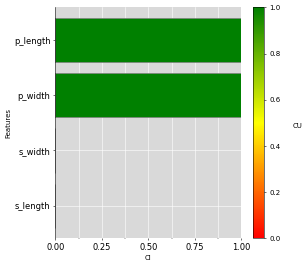

In [7]:
import matplotlib.pylab as py_plt
py_plt.rcParams['figure.dpi'] = 50
iris_ciu.plot_ciu()

We can also get a **"Why not?"** explanation for "Why not a Versicolor?":

In [8]:
iris_ciu = determine_ciu(
    instance,
    model.predict_proba,
    iris_df.to_dict('list'),
    samples = 100,
    prediction_index = np.where(y.cat.categories=='versicolor')[0][0]
)
iris_ciu.explain_tabular()

Features,CI,CU,cmin,cmax,outval
s_length,0.000138,0.024852,8.849858e-10,0.000138,0.000003
s_width,0.000220,0.015363,5.262932e-08,0.000220,0.000003
p_length,0.999998,0.000003,1.572366e-09,0.999998,0.000003
p_width,0.999999,0.000003,5.526147e-07,1.000000,0.000003


We see that Petal length and Petal width are also here the most(/only) relevant features with CI~=1. However, the CU values are almost zero so this is definitely not a Versicolor. 

**Remark:** There's a need for some refactoring here because it doesn't make sense to redo the CIU calculation just for another output index...

## Boston Housing example

We start by getting the Boston data and preparing it:

In [9]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

data = pd.DataFrame(data)
data.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

Then train an XGB model for predicting Boston house prices based on the data set:

In [10]:
import xgboost as xgb
#xgb.DMatrix(data=data,label=target)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=123)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, ...)

We choose an instance from the test set to explain:

In [11]:
inst_ind = np.argmax(xg_reg.predict(X_test)) # Test set instance with highest price estimate, so we expect a "positive" explanation.
instance = X_test.iloc[[inst_ind]]
inst_val = y_test[inst_ind]
pred = xg_reg.predict(instance)[0]
print(f"Instance {inst_ind} in the test set has a real price of ${inst_val:.0f} and a predicted price of ${pred:.0f}")
print(f"The instance values are:\n{instance}")

Instance 17 in the test set has a real price of $43 and a predicted price of $34
The instance values are:
        CRIM    ZN  INDUS  CHAS    NOX    RM   AGE     DIS  RAD    TAX  \
261  0.53412  20.0   3.97   0.0  0.647  7.52  89.4  2.1398  5.0  264.0   

     PTRATIO       B  LSTAT  
261     13.0  388.37   7.26  


We need to know the minimal and maximal price values in order to know how cheap or expensive the instance is:

In [12]:
print(f"The minimal price in the training set is ${min(y_train):.0f} and the maximal price is ${max(y_train):.0f}")

The minimal price in the training set is $5 and the maximal price is $50


Then get CIU Object and show tabular results:

In [13]:
boston_ciu = determine_ciu(
    instance,
    xg_reg.predict,
    data.to_dict('list'),
    samples = 100,
    prediction_index = None
)
boston_ciu.explain_tabular()

Features,CI,CU,cmin,cmax,outval
CRIM,0.523232,1.000000,31.502943,34.023457,34.023457
ZN,0.092586,1.000000,33.577450,34.023457,34.023457
INDUS,0.533172,1.000000,31.455057,34.023457,34.023457
CHAS,0.000000,0.001000,34.023457,34.023457,34.023457
NOX,0.456188,1.000000,31.825907,34.023457,34.023457
RM,0.700479,1.000000,30.649109,34.023457,34.023457
AGE,0.429708,1.000000,31.953468,34.023457,34.023457
DIS,0.482214,0.904325,31.922781,34.245701,34.023457
RAD,0.000000,0.001000,34.023457,34.023457,34.023457
TAX,0.404232,1.000000,32.076191,34.023457,34.023457


Now we can also plot the CI/CU values using the CIU Object's ``plot_ciu`` function

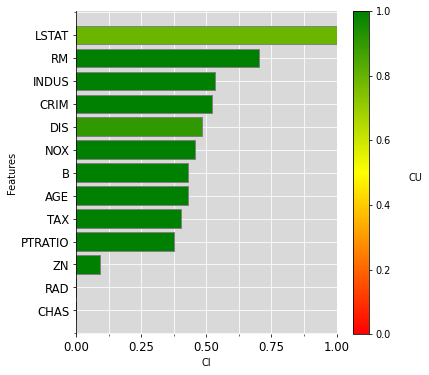

In [14]:
py_plt.rcParams['figure.dpi'] = 70
boston_ciu.plot_ciu() # Default plot, using colour codes

Likewise there are also several options available using the following parameters:

* ``plot_mode``: defines the type plot to use between 'default', 'overlap' and 'combined'.            
* ``include``: defines whether to include interactions or not.                                        
* ``sort``: defines the order of the plot bars by the 'ci' (default), 'cu' values or unsorted if None.
* ``color_blind``: defines accessible color maps to use for the plots, such as 'protanopia', 'deuteranopia' and 'tritanopia'.                           
* ``color_edge_cu``: defines the hex or named color for the CU edge in the overlap plot mode.         
* ``color_fill_cu``: defines the hex or named color for the CU fill in the overlap plot mode.         
* ``color_edge_ci``: defines the hex or named color for the CI edge in the overlap plot mode.         
* ``color_fill_ci``: defines the hex or named color for the CI fill in the overlap plot mode.         

Here's an example using some of these parameters to create a modified version of the above plot 

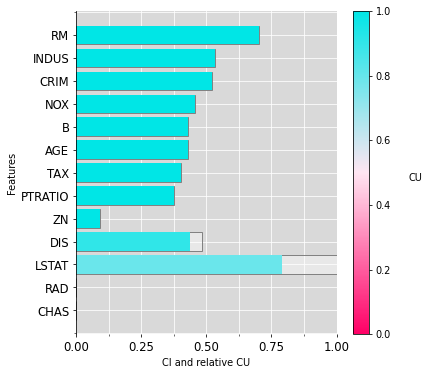

In [15]:
boston_ciu.plot_ciu(plot_mode="combined", color_blind='tritanopia', sort='cu')

## Contextual influence

Contextual influence is calculated from CI and CU as follows:

$$
\phi_{j,\{i\},\{I\}}(x)=\omega_{j,\{i\},\{I\}}(x)(CU_{j,\{i\}}(x) - \phi_{0}),
$$

where $\phi_{0}$ is the *baseline/reference* value ($y(u(0))$ in the
plot). For instance, $\phi_{0}=0.5$ signifies using the average utility
value $0.5$ as the baseline, which is the case in the $age$ plot above.
An explanation using Contextual influence on the titanic dataset can be obtained as follows:

*Note*: the dataset and model used are not identical to the R version, 
therefore the results will see a slight variance. 

In [16]:
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv("https://raw.githubusercontent.com/KaryFramling/py-ciu/master/ciu_tests/data/titanic.csv")
data = data.drop(data.columns[0], axis=1)
unused = ['PassengerId','Cabin','Name','Ticket']

for col in unused:
    data = data.drop(col, axis=1)

from sklearn.preprocessing import LabelEncoder
data = data.dropna().apply(LabelEncoder().fit_transform)
train = data.drop('Survived', axis=1)

model = RandomForestClassifier(n_estimators=100)
model.fit(train, data.Survived)

RandomForestClassifier()

Create a new instance to explain:

In [17]:
# Create test instance (8-year old boy)
new_passenger = pd.DataFrame.from_dict({"Pclass" : [1], "Sex": [1], "Age": [8], "SibSp": [0], "Parch": [0], "Fare": [72], "Embarked": [2]})

Let's check out some basic things about the instance:

In [18]:
surv_prob = model.predict_proba(new_passenger)
print(f"The estimated probability of survival is {surv_prob[0,1]:.2f}.")
titanic_train_probs = model.predict_proba(train)
print(titanic_train_probs.shape)
mean_surv_prob = np.mean(titanic_train_probs[:,1])
print(f"The mean probability of survival in the training set is {mean_surv_prob:.2f}.")

The estimated probability of survival is 0.50.
(712, 2)
The mean probability of survival in the training set is 0.41.


We use the mean probability of survival as the 'normalCU' value of Contextual influence for consistency with the SHAP example further down. Here we show a bar chart using Contextual Influence:

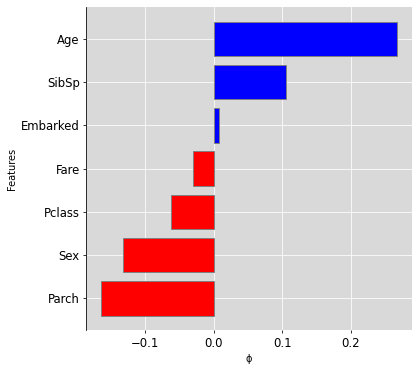

In [19]:
ciu_titanic = determine_ciu(
    new_passenger,
    model.predict_proba,
    train.to_dict('list'),
    samples = 1000,
    prediction_index = 1
)
ciu_titanic.plot_ciu(use_influence=True, neutralCU=mean_surv_prob)

**Remark:** The Equation for Contextual influence is similar to the
definition of Shapley values for linear models, except that the input
value $x_{i}$ is replaced by its utility value(s) $CU_{j,\{i\}}(x)$. In
practice, **all *Additive Feature Attribution (AFA)* methods estimate
influence values, not feature importance. Most state-of-the-art methods
such as *Shapley values*, *LIME*,** are AFA methods.

Influence values give no counter-factual information and are easily
misinterpreted. Below, we create a Shapley value explanation using the
shap package. In that explanation, for instance the close-to-zero Shapley
value for $Parch$ gives the impression that it’s a non-important
feature, which is clearly wrong based on the CIU explanation.

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


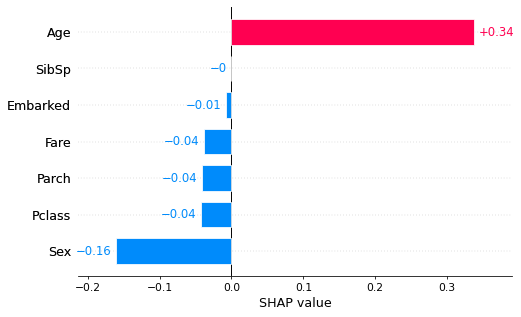

In [20]:
import shap
explainer = shap.Explainer(model, train)
shap_values = explainer(new_passenger)
shap.plots.bar(shap_values[0,:,1], order=np.argsort(shap_values[0,:,1].values)[::-1])

## Intermediate Concepts

CIU can use named feature coalitions and structured vocabularies. 
Such vocabularies allow explanations at any abstraction level and can make explanations interactive.

The following code snippet plots the joint effect of features $age$ and
$parch$ for the studied Titanic case (applicable for numeric features).
It therefore shows how the coalition of those two features affects the
output value and how CI and CU can be deduced in the same way as for a
single feature.

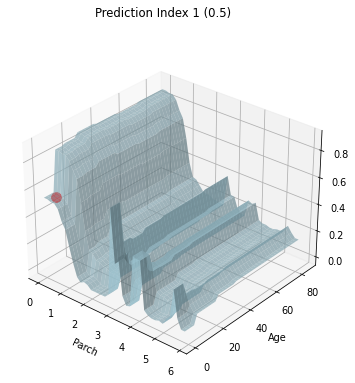

In [21]:
ciu_titanic.plot_3D(ind_inputs=[4,2])

### Titanic Example

We define a small vocabulary for Titanic as follows:

In [22]:
intermediate_tit = [
        {"Wealth":['Pclass', 'Fare']},
        {"Family":['SibSp', 'Parch']},
        {"Gender":['Sex']},
        {"Age_years":['Age']},
        {"Embarked_Place":['Embarked']}
    ]

Then we create a new CIU object that uses that vocabulary and get
top-level explanation.

In [23]:
ciu_titanic = determine_ciu(
    new_passenger,
    model.predict_proba,
    train.to_dict('list'),
    samples = 1000,
    prediction_index = 1,
    intermediate_concepts=intermediate_tit
)

First barplot explanation:

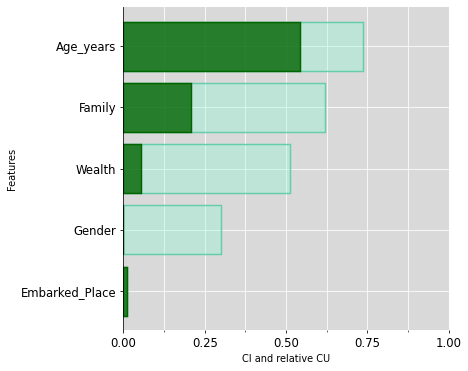

In [24]:
ciu_titanic.plot_ciu(include_intermediate_concepts='only', plot_mode='overlap')

Then explain WEALTH and FAMILY

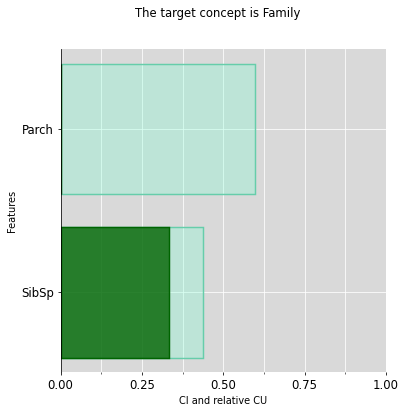

In [25]:
ciu_titanic.plot_ciu(target_concept="Family", plot_mode="overlap")

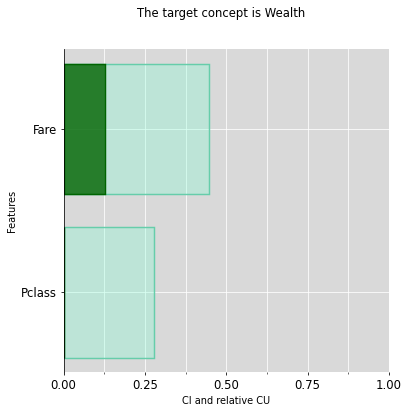

In [26]:
ciu_titanic.plot_ciu(target_concept="Wealth", plot_mode="overlap")

Same thing using textual explanations:

In [27]:
ciu_titanic.explain_text(include_intermediate_concepts="only")

['The feature "Wealth", which is of normal importance (CI=51.09%), is not typical for its prediction (CU=10.64%).',
 'The feature "Family", which is of high importance (CI=61.96%), is somewhat typical for its prediction (CU=33.33%).',
 'The feature "Gender", which is of low importance (CI=29.91%), is not typical for its prediction (CU=0.1%).',
 'The feature "Age_years", which is of high importance (CI=73.73%), is typical for its prediction (CU=73.71%).',
 'The feature "Embarked_Place", which is of very low importance (CI=1.09%), is very typical for its prediction (CU=100.0%).']

In [28]:
ciu_titanic.explain_text(target_concept="Family")

['The intermediate concept "Family", is somewhat typical for its prediction (CU=33.33%).',
 'The feature "SibSp", which is of normal importance (CI=43.86%), is very typical for its prediction (CU=76.0%).',
 'The feature "Parch", which is of normal importance (CI=59.65%), is not typical for its prediction (CU=0.1%).']

In [29]:
ciu_titanic.explain_text(target_concept="Wealth")

['The intermediate concept "Wealth", is not typical for its prediction (CU=10.64%).',
 'The feature "Pclass", which is of low importance (CI=27.66%), is not typical for its prediction (CU=0.1%).',
 'The feature "Fare", which is of normal importance (CI=44.68%), is somewhat typical for its prediction (CU=28.57%).']

## Ames Housing Example

Ames housing is a data set about properties in the town Ames in the US. It contains over 80 features that can be used for learning to estimate the sales price. The following code imports the data set (make sure that you have the path to the CSV file set correctly!), does some pre-processing and trains a Gradient Boosting model:

In [30]:
#from ciu.ciu_core import determine_ciu
#import pandas as pd
#import xgboost as xgb
#from sklearn.model_selection import train_test_split

df = pd.read_csv('ciu_tests/data/AmesHousing.csv')

#Checking for missing data
missing_data_count = df.isnull().sum()
missing_data_percent = df.isnull().sum() / len(df) * 100

missing_data = pd.DataFrame({
    'Count': missing_data_count,
    'Percent': missing_data_percent
})

missing_data = missing_data[missing_data.Count > 0]
missing_data.sort_values(by='Count', ascending=False, inplace=True)

#This one has spaces for some reason
df.columns = df.columns.str.replace(' ', '')


#Taking care of missing values
from sklearn.impute import SimpleImputer
# Group 1:
group_1 = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'
]
df[group_1] = df[group_1].fillna("None")

# Group 2:
group_2 = [
    'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
    'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'
]

df[group_2] = df[group_2].fillna(0)

# Group 3:
group_3a = [
    'Functional', 'MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st',
    'Exterior2nd', 'SaleType', 'Utilities'
]

imputer = SimpleImputer(strategy='most_frequent')
df[group_3a] = pd.DataFrame(imputer.fit_transform(df[group_3a]), index=df.index)

df.LotFrontage = df.LotFrontage.fillna(df.LotFrontage.mean())
df.GarageYrBlt = df.GarageYrBlt.fillna(df.YearBuilt)

#Label encoding
from sklearn.preprocessing import LabelEncoder
df = df.apply(LabelEncoder().fit_transform)

data = df.drop(columns=['SalePrice'])
target = df.SalePrice

#Splitting and training
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=123)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.1, max_depth = 15, alpha = 10)

xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, ...)

We start with an “explanation” using all 80 basic features, which is not very readable and overly detailed for “ordinary” humans to understand:

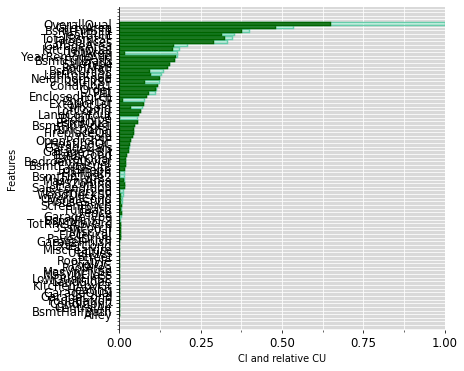

In [31]:
test_data_ames = X_test.iloc[[345]]

ciu_ames = determine_ciu(
    test_data_ames,
    xg_reg.predict,
    df.to_dict('list'),
    samples = 1000,
    prediction_index = None
)
ciu_ames.plot_ciu(plot_mode='overlap')

Then we create our vocabulary of intermediate concepts, in this case a list containing dictionaries of a `concept->[columns]` structure as follows:

In [32]:
intermediate = [
    {"Garage":list(df.columns[[58,59,60,61,62,63]])},
    {"Basement":list(df.columns[[30,31,33,34,35,36,37,38,47,48]])},
    {"Lot":list(df.columns[[3,4,7,8,9,10,11]])},
    {"Access":list(df.columns[[13,14]])},
    {"House_type":list(df.columns[[1,15,16,21]])},
    {"House_aesthetics":list(df.columns[[22,23,24,25,26]])},
    {"House_condition":list(df.columns[[17,18,19,20,27,28]])},
    {"First_floor_surface":list(df.columns[[43]])},
    {"Above_ground_living area":[c for c in df.columns if 'GrLivArea' in c]}
]

Now we can initialise the CIU object with a relatively expensive (which here corresponds to a "high utility") test case and our newly defined intermediate concepts:

In [33]:
ciu_ames = determine_ciu(
    test_data_ames,
    xg_reg.predict,
    df.to_dict('list'),
    samples = 1000,
    prediction_index = None,
    intermediate_concepts = intermediate
)

Then the same, using highest-level concepts:

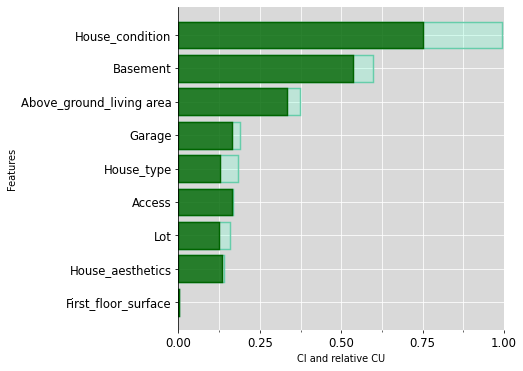

In [34]:
ciu_ames.plot_ciu(include_intermediate_concepts='only', plot_mode='overlap')

Then explain further some intermediate concepts:

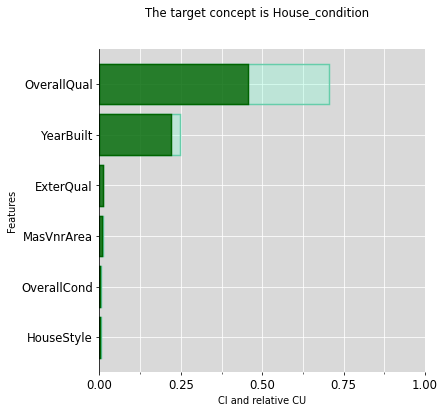

In [35]:
ciu_ames.plot_ciu(target_concept="House_condition", plot_mode="overlap")

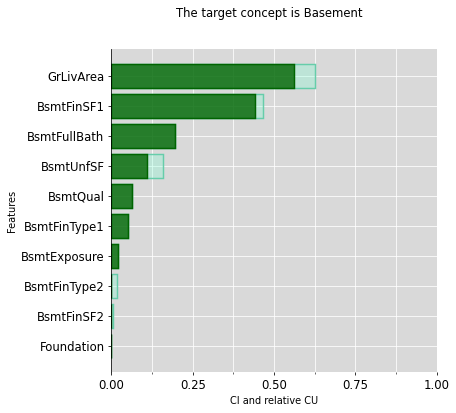

In [36]:
ciu_ames.plot_ciu(target_concept="Basement", plot_mode="overlap")

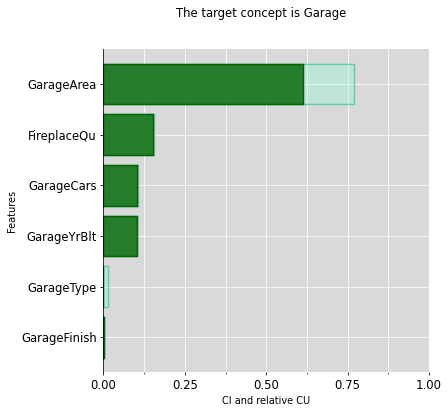

In [37]:
ciu_ames.plot_ciu(target_concept="Garage", plot_mode="overlap")

This vocabulary is just an example of what kind of concepts a human typically deals with. Vocabularies can be built freely (or learned, if possible) and used freely, even so that different vocabularies can be used with different users.